<a href="https://colab.research.google.com/github/berryew/DREAM-PTD-Prediction-Using-Microarray/blob/master/DREAM_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Install packages, import them, and load the dataset

In [0]:
!pip install imblearn
!pip install biopython

In [0]:
import pandas as pd
import numpy as np

from scipy import interp
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.utils import shuffle

import xgboost as xgb
from Bio.Cluster import kcluster
from collections import Counter

from sklearn.cluster import AgglomerativeClustering
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from pathlib import Path
DATA = Path("/content/drive/My Drive/E4060/DREAM/data")

In [0]:
# load the microarray
# Just `eset_SC2_v20.csv` and `anoSC2_v20_nokey.csv` will be sufficient. 
# `eset_SC2_v20.csv` contains information of both `HuGene21ST_RMA.csv` and `HTA20_RMA.csv`
eset = pd.read_csv(DATA / "eset_SC2_v20.csv", index_col=0)
# load the annotation
annot = pd.read_csv(DATA / "anoSC2_v20_nokey.csv")

### Define SampleID-IndividualID map, functions (sampling and clustering), and dicts to store plot information

In [0]:
# create a SampleID-IndividualID map, so that we can group by IndividualID and calculate the average
sample_to_individual = pd.Series(annot.IndividualID.values, index=annot.SampleID).to_dict()

In [0]:
'''
downsampling the majority class
`X_y` defines the training matrix, row: samples, column: genes + Group
`sep` defines the index to split columns into genes + annotation, e.g. Group
`df` defines the type of output
`seed` defines the random state
`shuffle` defines if shuffuling is needed
'''
def downsampling(X_y, sep=-1, df=False, seed=47, shuffle=False):
    True_samples = X_y[X_y.Group].index

    # Shuffle the Dataset.
    X_y = X_y.sample(frac=1, random_state=7)

    # Put all the positive samples in a separate dataset.
    True_X_y = X_y.loc[X_y.index.isin(True_samples)]

    # Randomly select observations from the negative samples
    False_X_y = X_y.loc[~X_y.index.isin(True_samples)].sample(n=len(True_samples), random_state=seed)

    # Concatenate both dataframes
    downsampled_X_y = pd.concat([True_X_y, False_X_y])

    # based on the type of output: dataframe or np.array
    if df:
        X, y = downsampled_X_y.iloc[:, :sep], downsampled_X_y.iloc[:, sep:]
    else:
        X, y = np.array(downsampled_X_y.iloc[:, :sep]), np.array(downsampled_X_y.iloc[:, sep:])

    
    # based on whether the output need shuffling
    if shuffle:
        return shuffle(X, y, random_state=seed)
    else:
        return X, y

In [0]:
'''
oversampling the minority class, use SMOTE from the library `imblearn`
`X_y` defines the training matrix, row: samples, column: genes + Group
`sep` defines the index to split columns into genes + annotation, e.g. Group
`df` defines the type of output
`seed` defines the random state
`shuffle` defines if shuffuling is needed
'''
def oversampling(X_y, sep=-1, df=False, seed=47, shuffle=False):
    # Resample the minority class.
    sm = SMOTE(sampling_strategy='minority', random_state=4060)

    # Fit the model to generate the data.
    X, y = sm.fit_sample(X_y.iloc[:, :sep], X_y.iloc[:, sep:])
    
    # based on the type of output: dataframe or np.array
    if df:
        X = pd.DataFrame(X, columns=X_y.columns[:-1])
        y = pd.DataFrame(y, columns=['Group'])
    
    # based on whether the output need shuffling
    if shuffle:
        return shuffle(X, y, random_state=seed)
    else:
        return X, y

In [0]:
'''
`X_train` defines the traning set
`X_test` defines the test set
`method` defines clustering methods, either kmeans or hierarchical 
    * the parameters of hierarchical clustering can be set as hierarchical.euclidean.average for example
`n_cluster` defines the maximum clusters
    * based on the cllustering, leave out clusters with much less genes, and generate the features by calculate the means of each cluster
`df` decides the type of output, pandas DataFrame or numpy array
'''
def mean_by_cluster(X_train, X_test, n_cluster=5, method='kmeans', df=True):
    
    # clustering, defined by argument `method`
    if method == 'kmeans':
        clusterid, error, nfound = kcluster(np.array(X_train.transpose()), nclusters=n_cluster)
    elif method.startswith('hierarchical'):
        _, affinity, linkage = method.split(".")
        cluster = AgglomerativeClustering(n_clusters=n_cluster, affinity=affinity, linkage=linkage)
        cluster.fit_predict(np.array(X_train.transpose()))
        clusterid = cluster.labels_

    sep = len(X_train)

    metagenes = pd.concat([X_train, X_test], axis=0, sort=False).transpose().copy()
    metagenes = metagenes.reset_index(drop=True)
    metagenes['id'] = clusterid
    metagenes['size'] = metagenes.groupby('id').size()
    # candidate_condition = metagenes['size'] > 0.4 * X.shape[1]//n_cluster
    candidate_condition = metagenes['size'] > max(0.4 * X.shape[1]//n_cluster, 3)
    # candidate_condition = metagenes['size'] > 4
    # print(metagenes.head(1))
    metagenes = metagenes.groupby('id').mean()
    # print(metagenes['size'] > 0.5 * X.shape[0]//n_cluster)
    metagenes = metagenes[candidate_condition].drop(columns='size')
    print('Before | After deleting clusters with much less objects: {} | {}'.format(Counter(clusterid), metagenes.shape[0]))
    
    if df:
        return metagenes.iloc[:, :sep].transpose(), metagenes.iloc[:, sep:].transpose()
    else:
        return np.array(metagenes.iloc[:, :sep].transpose()), np.array(metagenes.iloc[:, sep:].transpose())
    

In [0]:
# store plot information for comparison
# key: sampling/clustering/classfiers, value: (mean_fpr, mean_tpr, mean_auc, std_auc)
plot_sampling_dict = {}
plot_clustering_dict = {}
plot_clf_dict = {}

### Non-sampling vs. sampling


#### 'Without sampling', 'Adding class weights'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({2: 14, 3: 13, 0: 13, 6: 13, 5: 13, 7: 11, 1: 9, 8: 9, 4: 4, 9: 1}) | 8
True sample in training | test: 45 | 10
Before | After deleting clusters with much less objects: Counter({5: 14, 7: 14, 1: 13, 3: 13, 6: 13, 2: 12, 4: 10, 9: 5, 0: 4, 8: 2}) | 8
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({8: 14, 0: 13, 9: 13, 2: 13, 4: 12, 1: 12, 6: 11, 7: 7, 3: 4, 5: 1}) | 8
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({9: 14, 6: 13, 4: 13, 1: 13, 8: 12, 7: 12, 2: 9, 0: 6, 3: 5, 5: 3}) | 9
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({3: 16, 0: 13, 2: 13, 1: 12, 6: 11, 7: 11, 9: 9, 5: 8, 8: 6, 4: 1}) | 9
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({9: 14, 7: 13, 6: 13, 3: 13, 2: 12, 1: 12, 5: 11, 0:

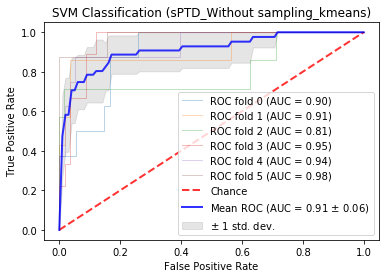

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({2: 14, 4: 14, 3: 13, 8: 13, 5: 13, 1: 12, 0: 9, 7: 6, 9: 5, 6: 1}) | 9
True sample in training | test: 45 | 10
Before | After deleting clusters with much less objects: Counter({2: 14, 6: 13, 7: 13, 8: 13, 3: 13, 5: 12, 4: 10, 1: 5, 0: 4, 9: 3}) | 8
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({1: 17, 9: 14, 0: 13, 5: 13, 7: 11, 8: 11, 3: 10, 2: 9, 4: 1, 6: 1}) | 8
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({8: 13, 4: 13, 3: 13, 2: 13, 0: 12, 9: 12, 1: 11, 6: 11, 5: 1, 7: 1}) | 8
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({4: 16, 0: 13, 2: 12, 5: 11, 8: 11, 7: 11, 3: 10, 9: 7, 1: 5, 6: 4}) | 9
True sample in training | test: 46 | 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({4: 14, 5: 13, 0: 13, 2: 13, 1: 13, 6: 12, 8: 11, 7: 7, 9: 3, 3: 1}) | 8
True sample in training | test: 46 | 9


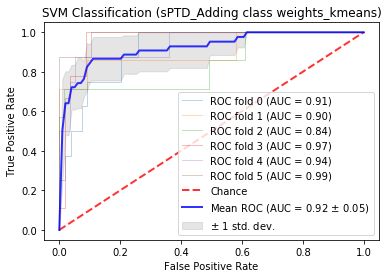

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({7: 15, 2: 15, 3: 12, 8: 12, 9: 11, 4: 10, 6: 10, 0: 7, 1: 7, 5: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({0: 15, 5: 15, 4: 12, 3: 11, 7: 11, 9: 11, 1: 10, 6: 7, 8: 7, 2: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({1: 19, 2: 15, 6: 14, 5: 12, 0: 12, 8: 7, 9: 7, 7: 7, 3: 6, 4: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({3: 15, 2: 14, 0: 13, 4: 11, 1: 11, 9: 11, 5: 10, 8: 7, 7: 7, 6: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({7: 20, 2: 16, 0: 15, 9: 11, 6: 11, 4: 11, 3: 7, 8: 7, 5: 1, 1: 1}) | 8
True sample in training | test: 79 | 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({6: 19, 1: 14, 5: 14, 2: 13, 3: 11, 8: 9, 9: 7, 4: 7, 7: 4, 0: 2}) | 8
True sample in training | test: 80 | 15


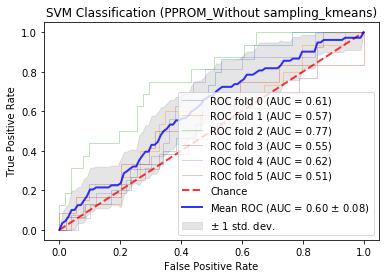

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({6: 15, 4: 15, 3: 12, 8: 12, 7: 11, 1: 10, 5: 10, 9: 7, 2: 7, 0: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({8: 20, 3: 16, 2: 15, 0: 11, 7: 11, 4: 11, 5: 7, 6: 7, 1: 1, 9: 1}) | 8
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({8: 15, 1: 15, 6: 12, 3: 12, 2: 11, 9: 10, 5: 10, 4: 7, 7: 7, 0: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({9: 15, 6: 14, 2: 13, 1: 12, 0: 11, 3: 11, 4: 9, 7: 7, 8: 7, 5: 1}) | 9
True sample in training | test: 79 | 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


Before | After deleting clusters with much less objects: Counter({0: 15, 1: 15, 9: 12, 6: 12, 7: 11, 5: 11, 4: 9, 2: 7, 8: 7, 3: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({9: 20, 7: 16, 1: 15, 2: 11, 4: 11, 8: 11, 0: 7, 5: 7, 6: 1, 3: 1}) | 8
True sample in training | test: 80 | 15


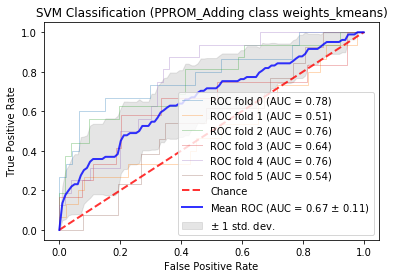

In [0]:
categories = ["sPTD", "PPROM"]
sampling = ['Without sampling', 'Adding class weights']
method = ['Without clustering', 'kmeans', 'hierarchical.euclidean.complete']
cv = StratifiedKFold(n_splits=6)
random_state = np.random.RandomState(0)

train_id = annot[annot.Train == 1]['SampleID']
test_id = annot[annot.Train == 0]['SampleID']

for category in categories:
    file_name = "topTable1000_" + category + ".csv"
    topTable = pd.read_csv(DATA / file_name, index_col=0)
    top_genes = topTable.index[:100]
    
    X_clf = eset.loc[eset.index.isin(top_genes), eset.columns.isin(train_id)].transpose()
    y_clf = annot.loc[annot.SampleID.isin(train_id), ['SampleID', 'Group']].set_index('SampleID')
    y_clf['Group'] = y_clf['Group'] == category
    X, y = shuffle(X_clf, y_clf, random_state=4060)
    


    for idx, s in enumerate(sampling):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        if idx == 1:
            classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state, class_weight='balanced')
        else:
            classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

        i = 0
        for train, test in cv.split(X, y.Group):    
            y_train, y_test = y.Group.iloc[train], y.Group.iloc[test]
            X_train, X_test = X.iloc[train], X.iloc[test]
            

            X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'kmeans', df=False)
            
            # X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'hierarchical.euclidean.complete', df=False)

            print("True sample in training | test: {} | {}".format(sum(y_train), sum(y_test)))
            # print("True sample in training | test: {} | {}".format(y_train.sum(), y_test.sum()))
            probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
            
            # Compute ROC curve and area the curve
            output = pd.DataFrame({'SampleID': X.iloc[test].index, 'Prediction': probas_[:, 1]})
            output['IndividualID'] = output['SampleID'].map(sample_to_individual)
            output = output.merge(y.iloc[test], on='SampleID')
            # output = pd.concat([output, y.iloc[test].reset_index(drop=True)], axis=1)
            output = output.groupby('IndividualID').mean()
            # output = output.groupby('IndividualID').apply(lambda x: x.sample(1)).reset_index(drop=True)
            
            # fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
            fpr, tpr, thresholds = roc_curve(output.Group, output.Prediction)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                    label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1

        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        
        plot_name = category + '_' + s + '_SVM_kmeans'
        plot_sampling_dict[plot_name] = (mean_fpr, mean_tpr, mean_auc, std_auc)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # plt.title('SVM Classification (' + category + '_' + s + '_Without clustering)')
        plt.title('SVM Classification (' + category + '_' + s + '_kmeans)')
        # plt.title('SVM Classification (' + category + '_' + s + '_hierarchical.euclidean.complete)')
        plt.legend(loc="lower right")
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/SVM Classification (' + category + '_' + s + '_Without clustering).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/SVM Classification (' + category + '_' + s + '_kmeans).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/SVM Classification (' + category + '_' + s + '_hierarchical.euclidean.complete).png')
        plt.show()



#### 'Downsampling', 'Oversampling'

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/va

Before | After deleting clusters with much less objects: Counter({2: 16, 0: 13, 9: 13, 1: 12, 8: 11, 6: 10, 3: 9, 5: 8, 4: 5, 7: 3}) | 9
True sample in training | test: 45 | 10
Before | After deleting clusters with much less objects: Counter({2: 13, 0: 12, 5: 12, 8: 12, 6: 12, 7: 11, 4: 9, 1: 9, 3: 5, 9: 5}) | 10
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({4: 14, 6: 14, 3: 13, 5: 13, 9: 13, 8: 12, 2: 9, 1: 5, 7: 4, 0: 3}) | 8
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({9: 17, 5: 13, 0: 12, 2: 12, 1: 11, 7: 10, 3: 9, 8: 8, 6: 5, 4: 3}) | 9
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({9: 14, 4: 13, 7: 13, 5: 13, 6: 11, 0: 11, 3: 10, 8: 8, 1: 6, 2: 1}) | 9
True sample in training | test: 46 | 9
Before | After deleting clusters with much less objects: Counter({4: 16, 0: 13, 2: 13, 6: 12, 7: 12, 3: 12, 1: 9, 9: 

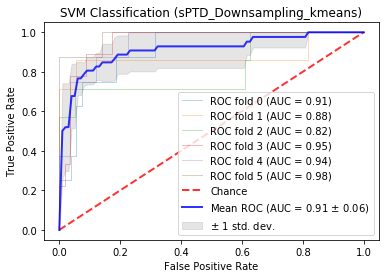

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({0: 17, 7: 13, 6: 12, 5: 12, 4: 12, 3: 9, 8: 9, 2: 7, 9: 6, 1: 3}) | 9
True sample in training | test: 316 | 10
Before | After deleting clusters with much less objects: Counter({9: 17, 1: 13, 3: 13, 0: 12, 7: 11, 6: 9, 8: 9, 4: 8, 2: 4, 5: 4}) | 8
True sample in training | test: 316 | 9
Before | After deleting clusters with much less objects: Counter({6: 17, 0: 13, 1: 12, 5: 11, 4: 11, 2: 10, 9: 9, 8: 9, 7: 5, 3: 3}) | 9
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({9: 17, 0: 13, 1: 13, 6: 12, 3: 11, 7: 9, 5: 9, 8: 7, 4: 6, 2: 3}) | 9
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({5: 17, 8: 14, 9: 13, 6: 13, 4: 12, 7: 10, 1: 9, 0: 7, 3: 4, 2: 1}) | 8
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({6: 17, 8: 13, 4: 12, 1: 12, 0: 12, 3: 12, 9: 9, 2: 9, 5: 3, 7: 1}) | 8
True sample in training | test: 317 | 9


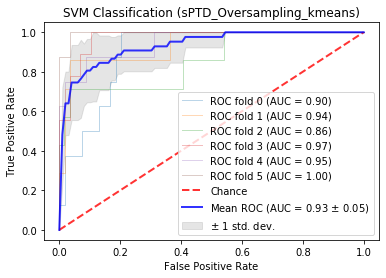

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/va

Before | After deleting clusters with much less objects: Counter({7: 16, 2: 15, 3: 12, 0: 11, 4: 11, 1: 10, 5: 10, 8: 7, 6: 7, 9: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({1: 19, 3: 15, 5: 12, 8: 11, 9: 10, 6: 10, 2: 8, 7: 7, 4: 7, 0: 1}) | 9
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({2: 20, 0: 16, 6: 15, 8: 11, 5: 7, 1: 7, 3: 7, 7: 6, 9: 6, 4: 5}) | 10
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({0: 20, 8: 16, 2: 15, 5: 11, 3: 11, 9: 11, 4: 7, 1: 7, 7: 1, 6: 1}) | 8
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({0: 19, 5: 15, 4: 14, 9: 13, 8: 12, 2: 11, 3: 7, 7: 7, 6: 1, 1: 1}) | 8
True sample in training | test: 79 | 16
Before | After deleting clusters with much less objects: Counter({1: 15, 2: 14, 0: 13, 8: 12, 4: 11, 3: 9, 5: 8, 6:

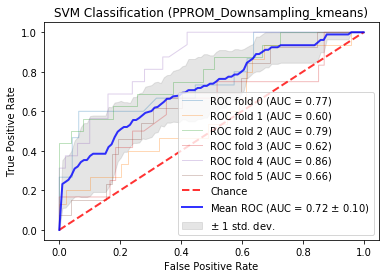

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({1: 15, 4: 15, 2: 12, 0: 12, 3: 11, 7: 10, 6: 10, 5: 7, 8: 7, 9: 1}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({6: 15, 7: 15, 1: 12, 4: 12, 3: 11, 0: 10, 9: 10, 5: 7, 8: 7, 2: 1}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({3: 15, 4: 14, 7: 13, 1: 12, 6: 11, 0: 10, 5: 10, 2: 7, 9: 7, 8: 1}) | 9
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

Before | After deleting clusters with much less objects: Counter({1: 15, 6: 15, 8: 12, 9: 12, 2: 11, 7: 10, 0: 10, 4: 7, 5: 7, 3: 1}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({9: 15, 5: 14, 3: 13, 1: 12, 7: 11, 0: 10, 4: 10, 2: 7, 6: 7, 8: 1}) | 9
True sample in training | test: 284 | 16
Before | After deleting clusters with much less objects: Counter({1: 15, 7: 15, 8: 12, 4: 11, 0: 11, 9: 10, 2: 7, 6: 7, 5: 7, 3: 5}) | 10
True sample in training | test: 284 | 15


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


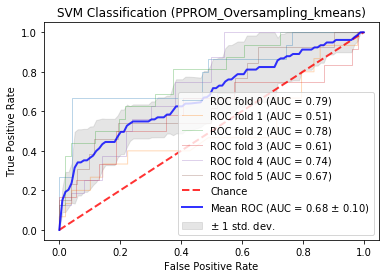

In [0]:
categories = ["sPTD", "PPROM"]
sampling = ['Downsampling', 'Oversampling']
cv = StratifiedKFold(n_splits=6)
random_state = np.random.RandomState(0)

train_id = annot[annot.Train == 1]['SampleID']
test_id = annot[annot.Train == 0]['SampleID']

for category in categories:
    file_name = "topTable1000_" + category + ".csv"
    topTable = pd.read_csv(DATA / file_name, index_col=0)
    top_genes = topTable.index[:100]
    
    X_clf = eset.loc[eset.index.isin(top_genes), eset.columns.isin(train_id)].transpose()
    y_clf = annot.loc[annot.SampleID.isin(train_id), ['SampleID', 'Group']].set_index('SampleID')
    y_clf['Group'] = y_clf['Group'] == category
    X, y = shuffle(X_clf, y_clf, random_state=4060)
    


    for idx, s in enumerate(sampling):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

        i = 0
        for train, test in cv.split(X, y.Group):
            X_train, X_test, y_train = X.iloc[train], X.iloc[test], y.Group.iloc[train]
            X_y_train = X_train.merge(y_train, left_index=True, right_index=True)
            y_test = y.Group.iloc[test]
            if idx == 0:
                X_train, y_train = downsampling(X_y_train, df=True)
            else:
                X_train, y_train = oversampling(X_y_train, df=True)
                

            X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'kmeans', df=False)
            
            # X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'hierarchical.euclidean.complete', df=False)
            # X_train, X_test = np.array(X.iloc[train]), np.array(X.iloc[test])
            print("True sample in training | test: {} | {}".format(y_train.values.sum(), y_test.values.sum()))
            probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
            
            # Compute ROC curve and area the curve
            output = pd.DataFrame({'SampleID': X.iloc[test].index, 'Prediction': probas_[:, 1]})
            output['IndividualID'] = output['SampleID'].map(sample_to_individual)
            output = output.merge(y.iloc[test], on='SampleID')
            # output = pd.concat([output, y.iloc[test].reset_index(drop=True)], axis=1)
            output = output.groupby('IndividualID').mean()
            # output = output.groupby('IndividualID').apply(lambda x: x.sample(1)).reset_index(drop=True)
            
            # fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
            fpr, tpr, thresholds = roc_curve(output.Group, output.Prediction)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                    label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1

        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        
        plot_name = category + '_' + s + '_SVM_kmeans'
        plot_sampling_dict[plot_name] = (mean_fpr, mean_tpr, mean_auc, std_auc)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # plt.title('SVM Classification (' + category + '_' + s + '_Without clustering)')
        plt.title('SVM Classification (' + category + '_' + s + '_kmeans)')
        # plt.title('SVM Classification (' + category + '_' + s + '_hierarchical.euclidean.complete)')
        plt.legend(loc="lower right")
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/SVM Classification (' + category + '_' + s + '_Without clustering).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/SVM Classification (' + category + '_' + s + '_kmeans).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/SVM Classification (' + category + '_' + s + '_hierarchical.euclidean.complete).png')
        plt.show()



#### Plot sampling comparison

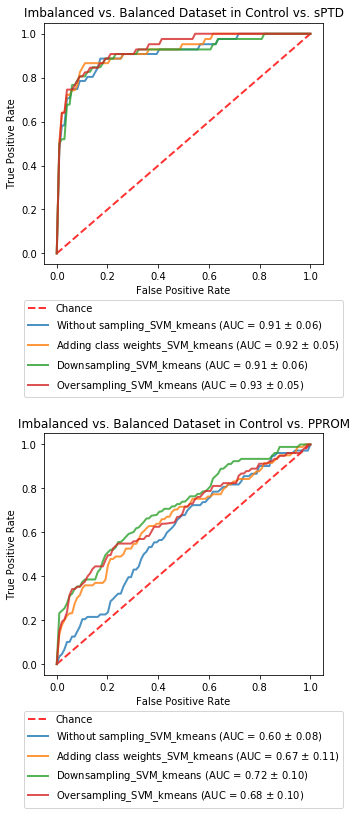

In [0]:
fig = plt.figure(figsize=(5, 12))
for idx, category in enumerate(['sPTD', 'PPROM']):
    ax = fig.add_subplot(2, 1, idx+1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    for k, v in plot_sampling_dict.items():
        if not k.startswith(category):
            continue
        mean_fpr, mean_tpr, mean_auc, std_auc = v
        plt.plot(mean_fpr, mean_tpr,
                label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (k[len(category)+1:], mean_auc, std_auc),
                lw=2, alpha=.8)


    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Imbalanced vs. Balanced Dataset in Control vs. '+category)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.57))
    # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplots_adjust(hspace=0.7)
plt.savefig('/content/drive/My Drive/E4060/DREAM/report/Imbalanced vs. Balanced Dataset.png')
plt.show()


### Classifiers

#### SVM, MLP, and Random Forest

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to

Before | After deleting clusters with much less objects: Counter({1: 13, 4: 13, 2: 12, 5: 12, 9: 11, 3: 11, 7: 10, 8: 7, 6: 6, 0: 5}) | 10
True sample in training | test: 316 | 10
Before | After deleting clusters with much less objects: Counter({0: 17, 5: 13, 9: 12, 8: 12, 7: 11, 4: 11, 1: 9, 2: 8, 3: 5, 6: 2}) | 9
True sample in training | test: 316 | 9
Before | After deleting clusters with much less objects: Counter({4: 17, 0: 14, 9: 13, 3: 13, 5: 13, 2: 11, 6: 10, 7: 4, 1: 4, 8: 1}) | 7
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to

Before | After deleting clusters with much less objects: Counter({7: 14, 4: 13, 3: 13, 0: 12, 6: 11, 1: 10, 8: 9, 2: 7, 9: 7, 5: 4}) | 9
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({7: 17, 0: 16, 9: 14, 6: 13, 3: 13, 5: 12, 1: 9, 8: 3, 4: 2, 2: 1}) | 7
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({3: 17, 4: 13, 5: 12, 2: 12, 1: 11, 7: 9, 8: 9, 9: 7, 0: 5, 6: 5}) | 10
True sample in training | test: 317 | 9


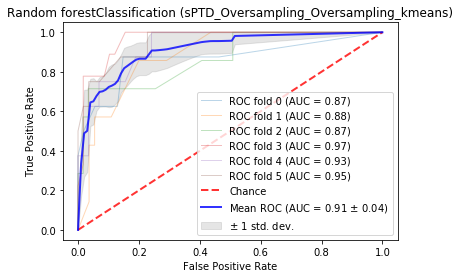

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({0: 17, 7: 13, 5: 12, 4: 12, 9: 11, 2: 10, 1: 10, 3: 10, 8: 4, 6: 1}) | 8
True sample in training | test: 316 | 10


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({8: 17, 1: 13, 4: 13, 5: 12, 3: 11, 2: 10, 7: 9, 0: 9, 9: 3, 6: 3}) | 8
True sample in training | test: 316 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({5: 18, 1: 13, 0: 12, 8: 11, 7: 11, 6: 10, 2: 10, 3: 8, 9: 4, 4: 3}) | 8
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({3: 13, 4: 13, 5: 12, 6: 11, 9: 11, 7: 10, 0: 9, 2: 9, 1: 8, 8: 4}) | 9
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({3: 13, 6: 13, 7: 13, 4: 12, 1: 12, 2: 10, 0: 9, 9: 9, 5: 6, 8: 3}) | 9
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({6: 17, 1: 13, 7: 12, 3: 12, 5: 12, 9: 10, 0: 9, 8: 8, 4: 5, 2: 2}) | 9
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


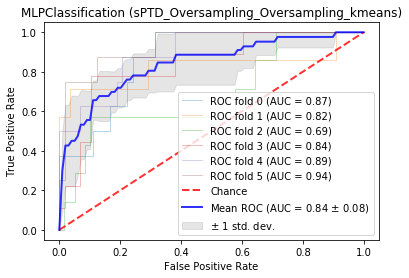

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({2: 16, 6: 13, 8: 13, 3: 12, 0: 12, 7: 11, 4: 10, 9: 7, 1: 5, 5: 1}) | 9
True sample in training | test: 316 | 10
Before | After deleting clusters with much less objects: Counter({8: 17, 2: 13, 7: 12, 4: 12, 9: 11, 3: 9, 6: 9, 0: 7, 5: 5, 1: 5}) | 10
True sample in training | test: 316 | 9
Before | After deleting clusters with much less objects: Counter({3: 13, 8: 13, 4: 11, 1: 11, 0: 11, 5: 10, 9: 10, 2: 9, 6: 7, 7: 5}) | 10
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({9: 17, 3: 13, 5: 13, 7: 12, 0: 12, 1: 9, 2: 8, 6: 7, 4: 5, 8: 4}) | 9
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({6: 16, 3: 13, 7: 12, 9: 12, 0: 11, 1: 11, 2: 9, 8: 8, 4: 7, 5: 1}) | 9
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({5: 17, 7: 13, 3: 12, 9: 12, 0: 11, 6: 11, 2: 9, 4: 7, 1: 6, 8: 2}) | 9
True sample in training | test: 317 | 9


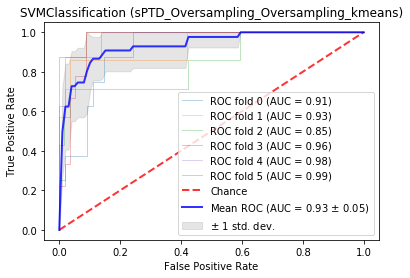

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to

Before | After deleting clusters with much less objects: Counter({1: 19, 7: 15, 6: 15, 2: 12, 8: 11, 5: 10, 0: 7, 9: 7, 3: 3, 4: 1}) | 8
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({0: 15, 5: 15, 1: 12, 4: 12, 9: 11, 6: 10, 8: 10, 3: 7, 7: 7, 2: 1}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({4: 15, 3: 14, 5: 13, 7: 12, 0: 11, 6: 10, 9: 10, 8: 7, 2: 7, 1: 1}) | 9
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to

Before | After deleting clusters with much less objects: Counter({6: 15, 2: 15, 9: 12, 4: 12, 8: 11, 1: 10, 5: 10, 0: 7, 7: 7, 3: 1}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({6: 19, 2: 15, 4: 15, 5: 12, 3: 11, 8: 10, 1: 7, 9: 7, 0: 3, 7: 1}) | 8
True sample in training | test: 284 | 16
Before | After deleting clusters with much less objects: Counter({3: 19, 1: 15, 8: 12, 2: 11, 6: 10, 9: 10, 7: 7, 5: 7, 4: 7, 0: 2}) | 9
True sample in training | test: 284 | 15


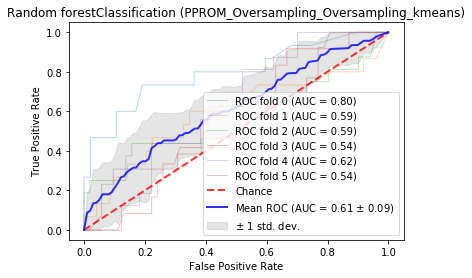

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({5: 19, 0: 15, 7: 15, 2: 13, 3: 11, 9: 11, 4: 7, 1: 7, 6: 1, 8: 1}) | 8
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({1: 15, 5: 15, 9: 12, 4: 12, 3: 11, 0: 10, 8: 10, 2: 7, 7: 7, 6: 1}) | 9
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({9: 15, 6: 14, 0: 13, 4: 12, 2: 11, 3: 8, 1: 7, 7: 7, 8: 7, 5: 6}) | 10
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({4: 15, 2: 15, 8: 12, 0: 12, 5: 11, 7: 10, 1: 10, 3: 7, 9: 7, 6: 1}) | 9
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({5: 18, 4: 15, 2: 14, 1: 13, 9: 13, 8: 11, 6: 7, 7: 7, 3: 1, 0: 1}) | 8
True sample in training | test: 284 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:921: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Before | After deleting clusters with much less objects: Counter({7: 19, 4: 15, 3: 15, 1: 12, 6: 11, 8: 10, 0: 7, 2: 7, 5: 3, 9: 1}) | 8
True sample in training | test: 284 | 15


/usr/local/lib/python3.6/dist-packages/sklearn/neural_network/multilayer_perceptron.py:566: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


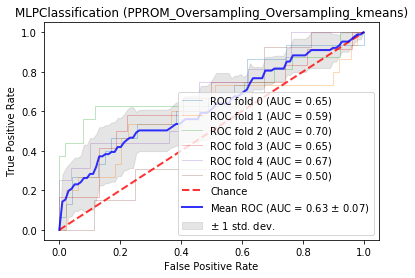

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({5: 15, 3: 15, 7: 12, 6: 12, 9: 11, 0: 10, 4: 10, 1: 7, 8: 7, 2: 1}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({3: 19, 5: 15, 1: 15, 9: 13, 4: 11, 2: 11, 6: 7, 7: 7, 8: 1, 0: 1}) | 8
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({5: 15, 4: 14, 9: 13, 3: 12, 6: 11, 1: 10, 2: 10, 0: 7, 7: 7, 8: 1}) | 9
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({1: 17, 7: 15, 5: 15, 9: 14, 4: 12, 8: 11, 3: 7, 2: 7, 0: 1, 6: 1}) | 8
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({9: 15, 0: 14, 6: 13, 2: 12, 3: 11, 1: 10, 7: 10, 8: 7, 4: 7, 5: 1}) | 9
True sample in training | test: 284 | 16
Before | After deleting clusters with much less objects: Counter({1: 15, 6: 15, 7: 12, 0: 12, 4: 11, 9: 10, 2: 10, 5: 7, 8: 7, 3: 1}) | 9
True sample in training | test: 284 | 15


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


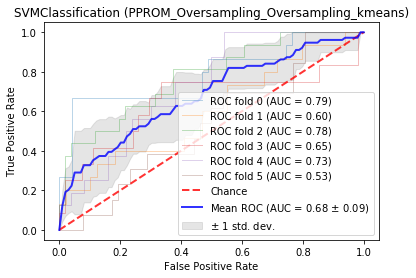

In [0]:
categories = ["sPTD", "PPROM"]
random_state = np.random.RandomState(0)
clf = {'Random forest': RandomForestClassifier(max_depth=10, n_estimators=10, random_state=random_state),
       'MLP': MLPClassifier(alpha=1, max_iter=100, random_state=random_state),
       'SVM': svm.SVC(kernel='linear', probability=True, random_state=random_state)}
cv = StratifiedKFold(n_splits=6)


train_id = annot[annot.Train == 1]['SampleID']
test_id = annot[annot.Train == 0]['SampleID']


for category in categories:
    file_name = "topTable1000_" + category + ".csv"
    topTable = pd.read_csv(DATA / file_name, index_col=0)
    top_genes = topTable.index[:100]
    
    X_clf = eset.loc[eset.index.isin(top_genes), eset.columns.isin(train_id)].transpose()
    y_clf = annot.loc[annot.SampleID.isin(train_id), ['SampleID', 'Group']].set_index('SampleID')
    y_clf['Group'] = y_clf['Group'] == category
    X, y = shuffle(X_clf, y_clf, random_state=4060)


    for k, v in clf.items():
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        classifier = v

        i = 0
        for train, test in cv.split(X, y.Group):
            X_train, X_test, y_train = X.iloc[train], X.iloc[test], y.Group.iloc[train]
            X_y_train = X_train.merge(y_train, left_index=True, right_index=True)
            y_test = y.Group.iloc[test]
            X_train, y_train = oversampling(X_y_train, df=True)

            X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'kmeans', df=False)
            
            # X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'hierarchical.euclidean.complete', df=False)
            # X_train, X_test = np.array(X.iloc[train]), np.array(X.iloc[test])
            print("True sample in training | test: {} | {}".format(y_train.values.sum(), y_test.values.sum()))
            probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
            
            # Compute ROC curve and area the curve
            output = pd.DataFrame({'SampleID': X.iloc[test].index, 'Prediction': probas_[:, 1]})
            output['IndividualID'] = output['SampleID'].map(sample_to_individual)
            output = output.merge(y.iloc[test], on='SampleID')
            # output = pd.concat([output, y.iloc[test].reset_index(drop=True)], axis=1)
            output = output.groupby('IndividualID').mean()
            # output = output.groupby('IndividualID').apply(lambda x: x.sample(1)).reset_index(drop=True)
            
            # fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
            fpr, tpr, thresholds = roc_curve(output.Group, output.Prediction)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                    label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1

        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        
        plot_name = category + '_' + k + '_Oversampling_kmeans'
        plot_clf_dict[plot_name] = (mean_fpr, mean_tpr, mean_auc, std_auc)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # plt.title(k + 'Classification (' + category + '_' + s + '_Without clustering)')
        plt.title(k + 'Classification (' + category + '_' + s + '_Oversampling_kmeans)')
        # plt.title(k + 'Classification (' + category + '_' + s + '_hierarchical.euclidean.complete)')
        plt.legend(loc="lower right")
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/' + k + 'Classification (' + category + '_' + s + '_Without clustering).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/' + k + 'Classification (' + category + '_' + s + '_kmeans).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/' + k + 'Classification (' + category + '_' + s + '_hierarchical.euclidean.complete).png')
        plt.show()


#### Plot classifier comparison

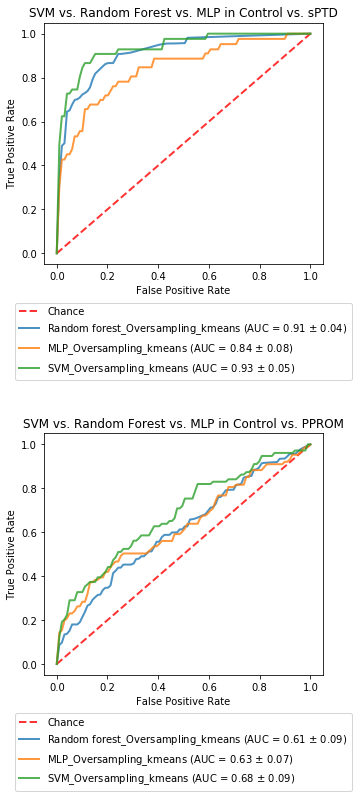

In [0]:
fig = plt.figure(figsize=(5, 12))
for idx, category in enumerate(['sPTD', 'PPROM']):
    ax = fig.add_subplot(2, 1, idx+1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    for k, v in plot_clf_dict.items():
        if not k.startswith(category):
            continue
        mean_fpr, mean_tpr, mean_auc, std_auc = v
        plt.plot(mean_fpr, mean_tpr,
                label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (k[len(category)+1:], mean_auc, std_auc),
                lw=2, alpha=.8)


    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('SVM vs. Random Forest vs. MLP in Control vs. '+category)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
    # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplots_adjust(hspace=0.7)
plt.savefig('/content/drive/My Drive/E4060/DREAM/report/SVM vs. Random Forest vs. MLP.png')
plt.show()

### Non-clustering vs. clustering

#### 'Without clustering', 'kmeans', 'hierarchical'

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

True sample in training | test: 316 | 10
True sample in training | test: 316 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

True sample in training | test: 317 | 9
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

True sample in training | test: 317 | 9
True sample in training | test: 317 | 9


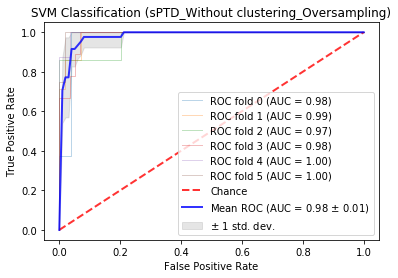

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({4: 17, 0: 13, 1: 12, 7: 11, 5: 11, 2: 10, 6: 8, 9: 7, 3: 6, 8: 5}) | 10
True sample in training | test: 316 | 10
Before | After deleting clusters with much less objects: Counter({5: 13, 7: 13, 0: 12, 4: 12, 6: 10, 9: 10, 3: 9, 8: 8, 1: 7, 2: 6}) | 10
True sample in training | test: 316 | 9
Before | After deleting clusters with much less objects: Counter({1: 17, 8: 13, 4: 13, 3: 12, 6: 11, 9: 11, 5: 10, 0: 8, 7: 3, 2: 2}) | 8
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({8: 17, 9: 13, 7: 13, 3: 12, 1: 12, 6: 11, 5: 10, 4: 9, 0: 2, 2: 1}) | 8
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({2: 17, 0: 13, 7: 12, 1: 12, 9: 10, 5: 9, 4: 9, 6: 9, 3: 5, 8: 4}) | 9
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({4: 17, 2: 12, 0: 12, 3: 12, 9: 12, 6: 11, 8: 9, 1: 9, 5: 5, 7: 1}) | 9
True sample in training | test: 317 | 9


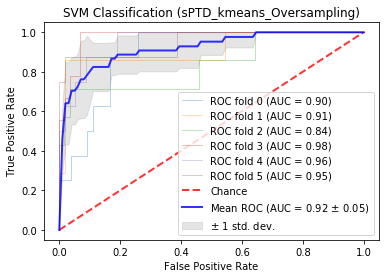

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({1: 22, 6: 16, 9: 15, 2: 13, 3: 10, 0: 9, 7: 9, 5: 3, 4: 2, 8: 1}) | 7
True sample in training | test: 316 | 10
Before | After deleting clusters with much less objects: Counter({0: 29, 8: 17, 2: 15, 1: 13, 4: 10, 6: 9, 5: 3, 3: 2, 9: 1, 7: 1}) | 6
True sample in training | test: 316 | 9
Before | After deleting clusters with much less objects: Counter({6: 22, 3: 18, 9: 14, 2: 13, 1: 10, 7: 9, 0: 8, 5: 3, 4: 2, 8: 1}) | 7
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({6: 25, 3: 18, 2: 13, 9: 11, 1: 10, 7: 9, 0: 8, 5: 3, 4: 2, 8: 1}) | 7
True sample in training | test: 317 | 9


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

Before | After deleting clusters with much less objects: Counter({9: 18, 7: 17, 6: 17, 2: 14, 1: 10, 0: 9, 3: 9, 5: 3, 4: 2, 8: 1}) | 7
True sample in training | test: 317 | 9
Before | After deleting clusters with much less objects: Counter({6: 21, 3: 17, 9: 15, 2: 13, 1: 10, 0: 9, 4: 9, 5: 3, 7: 2, 8: 1}) | 7
True sample in training | test: 317 | 9


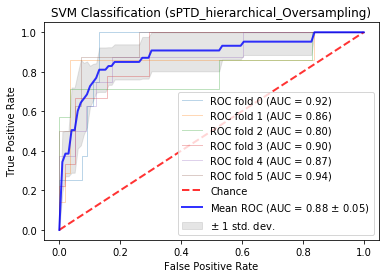

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

True sample in training | test: 283 | 16
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

True sample in training | test: 283 | 16
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example usin

True sample in training | test: 284 | 16
True sample in training | test: 284 | 15


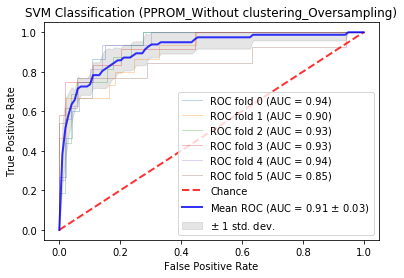

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({5: 15, 9: 15, 2: 12, 6: 11, 1: 11, 8: 10, 7: 10, 3: 7, 4: 7, 0: 2}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({4: 15, 6: 15, 3: 12, 0: 12, 5: 11, 9: 10, 8: 10, 2: 7, 1: 7, 7: 1}) | 9
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({2: 15, 8: 14, 9: 13, 3: 12, 6: 11, 1: 10, 4: 10, 0: 7, 7: 7, 5: 1}) | 9
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

Before | After deleting clusters with much less objects: Counter({5: 17, 4: 15, 2: 15, 0: 14, 8: 12, 6: 11, 9: 7, 1: 7, 7: 1, 3: 1}) | 8
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({6: 15, 0: 14, 4: 13, 2: 12, 3: 11, 5: 10, 1: 10, 8: 7, 9: 7, 7: 1}) | 9
True sample in training | test: 284 | 16
Before | After deleting clusters with much less objects: Counter({9: 15, 8: 15, 0: 12, 6: 12, 1: 11, 2: 10, 7: 10, 4: 7, 5: 7, 3: 1}) | 9
True sample in training | test: 284 | 15


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


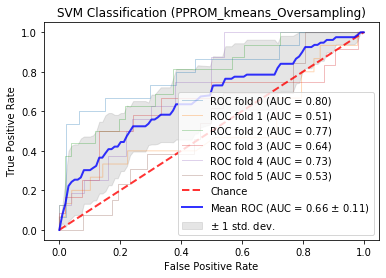

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning

Before | After deleting clusters with much less objects: Counter({1: 21, 6: 19, 0: 17, 3: 16, 4: 7, 8: 6, 7: 6, 5: 4, 2: 3, 9: 1}) | 7
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({2: 20, 3: 18, 8: 16, 6: 12, 1: 12, 0: 8, 4: 7, 5: 4, 7: 2, 9: 1}) | 7
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({2: 20, 3: 19, 9: 16, 1: 13, 6: 11, 0: 7, 4: 7, 5: 4, 7: 2, 8: 1}) | 7
True sample in training | test: 283 | 16


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples

Before | After deleting clusters with much less objects: Counter({2: 23, 6: 20, 1: 19, 3: 16, 0: 7, 4: 7, 5: 4, 7: 2, 8: 1, 9: 1}) | 6
True sample in training | test: 283 | 16
Before | After deleting clusters with much less objects: Counter({3: 21, 2: 19, 0: 17, 8: 16, 1: 7, 4: 7, 7: 6, 5: 4, 6: 2, 9: 1}) | 7
True sample in training | test: 284 | 16
Before | After deleting clusters with much less objects: Counter({3: 21, 2: 19, 1: 17, 8: 16, 4: 7, 6: 6, 7: 6, 5: 4, 0: 3, 9: 1}) | 7
True sample in training | test: 284 | 15


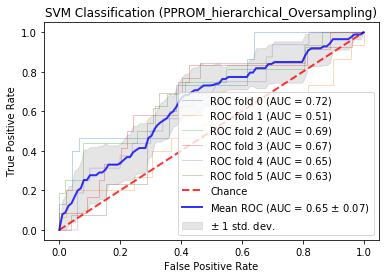

In [0]:
categories = ["sPTD", "PPROM"]
random_state = np.random.RandomState(0)
method = ['Without clustering', 'kmeans', 'hierarchical']
cv = StratifiedKFold(n_splits=6)


train_id = annot[annot.Train == 1]['SampleID']
test_id = annot[annot.Train == 0]['SampleID']


for category in categories:
    file_name = "topTable1000_" + category + ".csv"
    topTable = pd.read_csv(DATA / file_name, index_col=0)
    top_genes = topTable.index[:100]
    
    X_clf = eset.loc[eset.index.isin(top_genes), eset.columns.isin(train_id)].transpose()
    y_clf = annot.loc[annot.SampleID.isin(train_id), ['SampleID', 'Group']].set_index('SampleID')
    y_clf['Group'] = y_clf['Group'] == category
    X, y = shuffle(X_clf, y_clf, random_state=4060)


    for idx, m in enumerate(method):
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 100)

        classifier = svm.SVC(kernel='linear', probability=True, random_state=random_state)

        i = 0
        for train, test in cv.split(X, y.Group):
            X_train, X_test, y_train = X.iloc[train], X.iloc[test], y.Group.iloc[train]
            X_y_train = X_train.merge(y_train, left_index=True, right_index=True)
            y_test = y.Group.iloc[test]
            X_train, y_train = oversampling(X_y_train, df=True)
            
            if idx == 1:
                X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'kmeans', df=False)
            elif idx == 2:
                X_train, X_test = mean_by_cluster(X_train, X_test, 10, 'hierarchical.euclidean.complete', df=False)

            print("True sample in training | test: {} | {}".format(y_train.values.sum(), y_test.values.sum()))
            probas_ = classifier.fit(X_train, y_train).predict_proba(X_test)
            
            # Compute ROC curve and area the curve
            output = pd.DataFrame({'SampleID': X.iloc[test].index, 'Prediction': probas_[:, 1]})
            output['IndividualID'] = output['SampleID'].map(sample_to_individual)
            output = output.merge(y.iloc[test], on='SampleID')
            # output = pd.concat([output, y.iloc[test].reset_index(drop=True)], axis=1)
            output = output.groupby('IndividualID').mean()
            # output = output.groupby('IndividualID').apply(lambda x: x.sample(1)).reset_index(drop=True)
            
            # fpr, tpr, thresholds = roc_curve(y_test, probas_[:, 1])
            fpr, tpr, thresholds = roc_curve(output.Group, output.Prediction)
            tprs.append(interp(mean_fpr, fpr, tpr))
            tprs[-1][0] = 0.0
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            plt.plot(fpr, tpr, lw=1, alpha=0.3,
                    label='ROC fold %d (AUC = %0.2f)' % (i, roc_auc))

            i += 1

        plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
                label='Chance', alpha=.8)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = auc(mean_fpr, mean_tpr)
        std_auc = np.std(aucs)
        plt.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        
        plot_name = category + '_' + m + '_SVM_Oversampling'
        plot_clustering_dict[plot_name] = (mean_fpr, mean_tpr, mean_auc, std_auc)

        std_tpr = np.std(tprs, axis=0)
        tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
        plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')

        plt.xlim([-0.05, 1.05])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        # plt.title(k + 'Classification (' + category + '_' + s + '_Without clustering)')
        plt.title('SVM Classification (' + category + '_' + m + '_Oversampling)')
        # plt.title(k + 'Classification (' + category + '_' + s + '_hierarchical.euclidean.complete)')
        plt.legend(loc="lower right")
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/' + k + 'Classification (' + category + '_' + s + '_Without clustering).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/' + k + 'Classification (' + category + '_' + s + '_kmeans).png')
        # plt.savefig('/content/drive/My Drive/E4060/DREAM/report/' + k + 'Classification (' + category + '_' + s + '_hierarchical.euclidean.complete).png')
        plt.show()


#### Plot clustering comparison

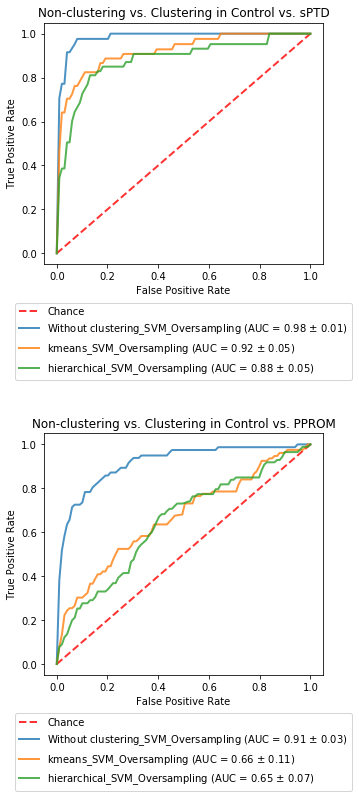

In [0]:
fig = plt.figure(figsize=(5, 12))
for idx, category in enumerate(['sPTD', 'PPROM']):
    ax = fig.add_subplot(2, 1, idx+1)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
            label='Chance', alpha=.8)

    for k, v in plot_clustering_dict.items():
        if not k.startswith(category):
            continue
        mean_fpr, mean_tpr, mean_auc, std_auc = v
        plt.plot(mean_fpr, mean_tpr,
                label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (k[len(category)+1:], mean_auc, std_auc),
                lw=2, alpha=.8)


    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Non-clustering vs. Clustering in Control vs. '+category)
    plt.legend(loc="lower center", bbox_to_anchor=(0.5, -0.5))
    # plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

plt.subplots_adjust(hspace=0.7)
plt.savefig('/content/drive/My Drive/E4060/DREAM/report/Non-clustering vs. Clustering.png')
plt.show()